# 🔍 Model Validation & Drift Detection

**Purpose**: Compare predictions vs actual outcomes, detect model drift, trigger retraining

**When to Run**:
- Weekly to validate past week's predictions
- Monthly for comprehensive model health check
- After significant events (holidays, weather events)

**Key Metrics**:
- Prediction accuracy (MAE, MAPE)
- Drift indicators
- Model version performance comparison


In [2]:
# ============================================================================
# SETUP
# ============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings

# Snowflake imports
from snowflake.ml.registry import Registry
from snowflake.snowpark import Session
from snowflake.snowpark.context import get_active_session

warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
print("✅ Imports loaded")


✅ Imports loaded


In [3]:
# Get Snowflake session (works in Snowsight notebooks)
try:
    session = get_active_session()
    print(f"✅ Connected to Snowflake")
    print(f"   Database: {session.get_current_database()}")
    print(f"   Schema: {session.get_current_schema()}")
    print(f"   Warehouse: {session.get_current_warehouse()}")
except:
    # Fallback for local development
    print("⚠️ Running locally - using connection config")
    import toml
    
    from pathlib import Path
    
    config_path = Path.home() / '.snowflake' / 'config.toml'
    sf_config = toml.load(config_path)
    conn_config = sf_config.get('connections', {}).get('snowflake_agents', {})
    
    session = Session.builder.configs({
        'account': conn_config.get('account'),
        'user': conn_config.get('user'),
        'password': conn_config.get('password'),
        'database': 'SKI_RESORT_DB',
        'schema': 'MARTS',
        'warehouse': conn_config.get('warehouse', 'COMPUTE_WH')
    }).create()
    print(f"✅ Connected locally")


⚠️ Running locally - using connection config
✅ Connected locally


In [ ]:
session.sql("""
    SELECT 
        input_date,
        model_version,
        predicted_visitors,
        prediction_timestamp,
        request_source
    FROM SKI_RESORT_DB.MARTS.ML_PREDICTION_LOG
    WHERE model_name = 'VISITOR_FORECASTER'
      AND model_version =
      AND input_date <= CURRENT_DATE()  -- Only past dates
""").to_pandas()

,INPUT_DATE,MODEL_VERSION,PREDICTED_VISITORS,PREDICTION_TIMESTAMP,REQUEST_SOURCE
0,2025-12-02,YOUNG_SHARK_1,411,2025-12-01 19:10:53.509,batch_script
1,2025-12-03,YOUNG_SHARK_1,355,2025-12-01 19:10:54.308,batch_script
2,2025-12-02,YOUNG_SHARK_1,372,2025-12-01 20:49:04.404,agent
3,2025-12-03,YOUNG_SHARK_1,372,2025-12-01 20:49:05.355,agent
4,2025-12-03,YOUNG_SHARK_1,372,2025-12-01 21:10:52.785,agent
5,2025-12-03,YOUNG_SHARK_1,355,2025-12-01 21:24:52.009,agent
6,2025-12-02,YOUNG_SHARK_1,355,2025-12-01 21:25:29.900,agent
7,2025-12-03,YOUNG_SHARK_1,355,2025-12-01 21:25:30.355,agent
8,2025-12-03,YOUNG_SHARK_1,411,2025-12-01 21:49:02.676,agent


## 1. Load Predictions vs Actuals


In [16]:
# ============================================================================
# JOIN PREDICTIONS WITH ACTUAL OUTCOMES
# ============================================================================
validation_query = """
WITH predictions AS (
    SELECT 
        input_date,
        model_version,
        predicted_visitors,
        prediction_timestamp,
        request_source
    FROM SKI_RESORT_DB.MARTS.ML_PREDICTION_LOG
    WHERE model_name = 'VISITOR_FORECASTER'
      AND input_date <= CURRENT_DATE()  -- Only past dates
),
actuals AS (
    SELECT 
        d.FULL_DATE as actual_date,
        COUNT(DISTINCT p.CUSTOMER_KEY) as actual_visitors
    FROM SKI_RESORT_DB.MARTS.DIM_DATE d
    LEFT JOIN SKI_RESORT_DB.MARTS.FACT_PASS_USAGE p ON p.DATE_KEY = d.DATE_KEY
    GROUP BY d.FULL_DATE
)
SELECT 
    p.input_date,
    p.model_version,
    p.predicted_visitors,
    a.actual_visitors,
    p.predicted_visitors - a.actual_visitors as error,
    ABS(p.predicted_visitors - a.actual_visitors) as abs_error,
    CASE WHEN a.actual_visitors > 0 
         THEN ABS(p.predicted_visitors - a.actual_visitors) / a.actual_visitors * 100 
         ELSE NULL END as pct_error,
    p.request_source,
    p.prediction_timestamp
FROM predictions p
JOIN actuals a ON p.input_date = a.actual_date
ORDER BY p.input_date DESC
"""

try:
    validation_df = session.sql(validation_query).to_pandas()
    print(f"✅ Loaded {len(validation_df)} prediction records with actuals")
    print(f"   Date range: {validation_df['INPUT_DATE'].min()} to {validation_df['INPUT_DATE'].max()}")
except Exception as e:
    print(f"⚠️ Could not load validation data: {e}")
    print("   (This is normal if no predictions have been logged yet)")
    validation_df = pd.DataFrame()


✅ Loaded 9 prediction records with actuals
   Date range: 2025-12-02 to 2025-12-03


In [23]:
validation_df

,INPUT_DATE,MODEL_VERSION,PREDICTED_VISITORS,ACTUAL_VISITORS,ERROR,ABS_ERROR,PCT_ERROR,REQUEST_SOURCE,PREDICTION_TIMESTAMP
0,2025-12-03,YOUNG_SHARK_1,355,503,-148,148,29.4235,batch_script,2025-12-01 19:10:54.308
1,2025-12-03,YOUNG_SHARK_1,372,503,-131,131,26.0437,agent,2025-12-01 20:49:05.355
2,2025-12-03,YOUNG_SHARK_1,372,503,-131,131,26.0437,agent,2025-12-01 21:10:52.785
3,2025-12-03,YOUNG_SHARK_1,355,503,-148,148,29.4235,agent,2025-12-01 21:24:52.009
4,2025-12-03,YOUNG_SHARK_1,355,503,-148,148,29.4235,agent,2025-12-01 21:25:30.355
5,2025-12-03,YOUNG_SHARK_1,411,503,-92,92,18.2903,agent,2025-12-01 21:49:02.676
6,2025-12-02,YOUNG_SHARK_1,411,486,-75,75,15.4321,batch_script,2025-12-01 19:10:53.509
7,2025-12-02,YOUNG_SHARK_1,372,486,-114,114,23.4568,agent,2025-12-01 20:49:04.404
8,2025-12-02,YOUNG_SHARK_1,355,486,-131,131,26.9547,agent,2025-12-01 21:25:29.900


## 2. Calculate Accuracy Metrics


In [18]:
# ============================================================================
# CALCULATE ACCURACY METRICS
# ============================================================================
if len(validation_df) > 0:
    # Overall metrics
    mae = validation_df['ABS_ERROR'].mean()
    mape = validation_df['PCT_ERROR'].mean()
    rmse = np.sqrt((validation_df['ERROR'] ** 2).mean())
    
    # Metrics by model version
    version_metrics = validation_df.groupby('MODEL_VERSION').agg({
        'ABS_ERROR': 'mean',
        'PCT_ERROR': 'mean',
        'INPUT_DATE': 'count'
    }).rename(columns={'ABS_ERROR': 'MAE', 'PCT_ERROR': 'MAPE', 'INPUT_DATE': 'Count'})
    
    print("📊 OVERALL PREDICTION ACCURACY")
    print("="*50)
    print(f"   MAE:  {mae:.0f} visitors")
    print(f"   MAPE: {mape:.1f}%")
    print(f"   RMSE: {rmse:.0f} visitors")
    
    print(f"\n📊 BY MODEL VERSION:")
    print(version_metrics.to_string())
    
    # Accuracy thresholds
    print(f"\n🎯 Quality Gate Check:")
    if mape < 15:
        print(f"   ✅ MAPE {mape:.1f}% < 15% threshold - Model performing well")
    elif mape < 25:
        print(f"   ⚠️ MAPE {mape:.1f}% - Model acceptable but consider retraining")
    else:
        print(f"   🔴 MAPE {mape:.1f}% > 25% - Model drift detected, retrain recommended!")
else:
    print("⚠️ No validation data available yet")


📊 OVERALL PREDICTION ACCURACY
   MAE:  124 visitors
   MAPE: 24.9%
   RMSE: 127 visitors

📊 BY MODEL VERSION:
                      MAE       MAPE  Count
MODEL_VERSION                              
YOUNG_SHARK_1  124.222222  24.943533      9

🎯 Quality Gate Check:
   ⚠️ MAPE 24.9% - Model acceptable but consider retraining


## 3. Visualization: Predicted vs Actual


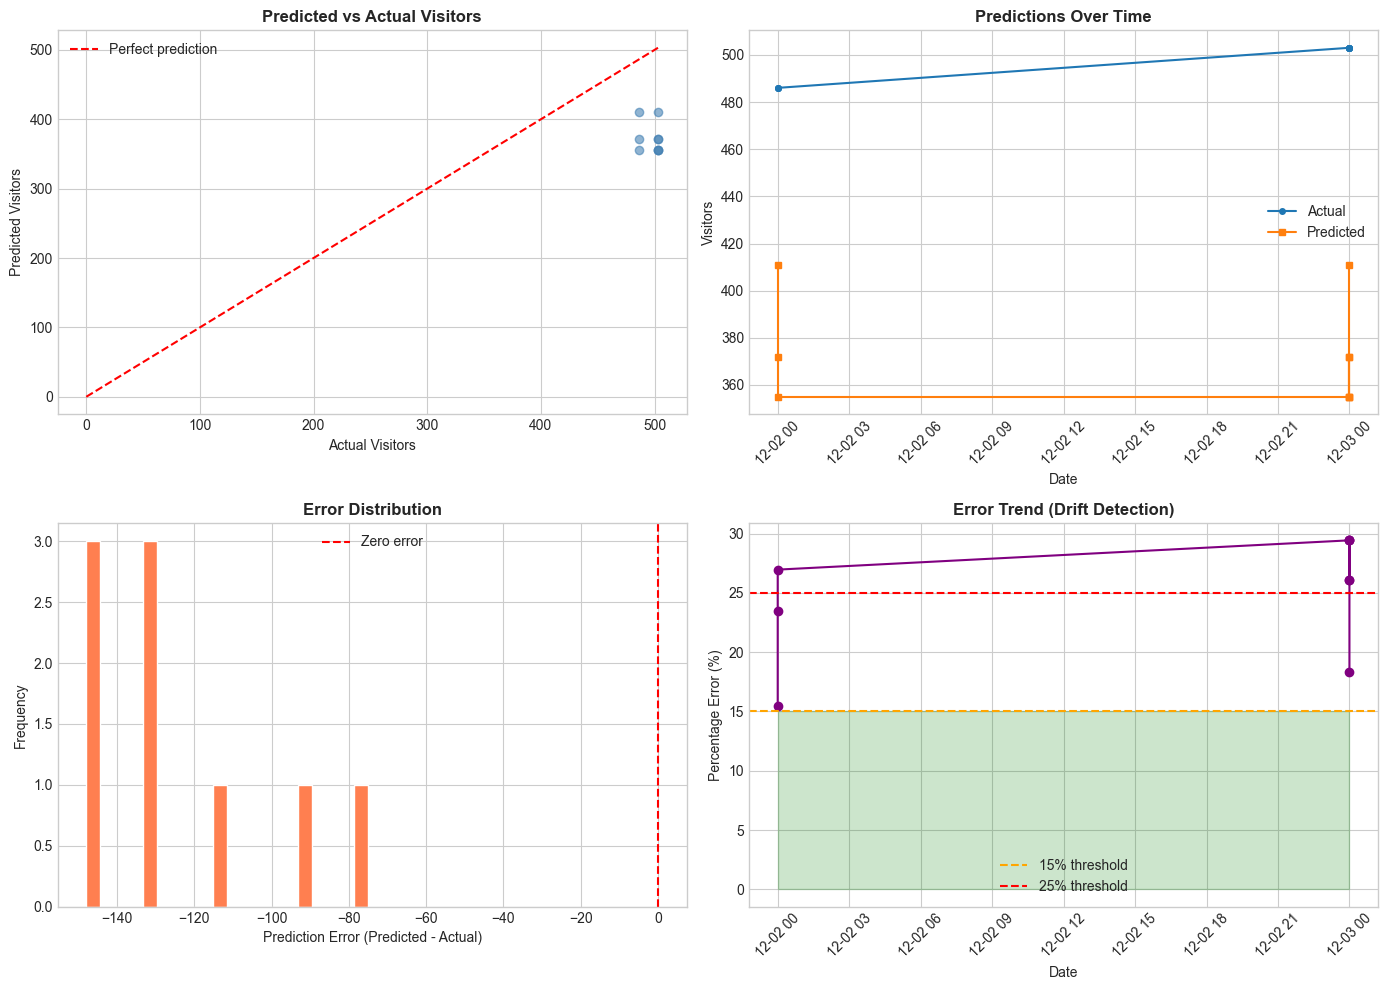

In [19]:
# ============================================================================
# VISUALIZATION: PREDICTED VS ACTUAL
# ============================================================================
if len(validation_df) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # 1. Scatter: Predicted vs Actual
    ax1 = axes[0, 0]
    ax1.scatter(validation_df['ACTUAL_VISITORS'], validation_df['PREDICTED_VISITORS'], 
                alpha=0.6, c='steelblue')
    max_val = max(validation_df['ACTUAL_VISITORS'].max(), validation_df['PREDICTED_VISITORS'].max())
    ax1.plot([0, max_val], [0, max_val], 'r--', label='Perfect prediction')
    ax1.set_xlabel('Actual Visitors')
    ax1.set_ylabel('Predicted Visitors')
    ax1.set_title('Predicted vs Actual Visitors', fontweight='bold')
    ax1.legend()
    
    # 2. Time series: Both lines
    ax2 = axes[0, 1]
    validation_df_sorted = validation_df.sort_values('INPUT_DATE')
    ax2.plot(validation_df_sorted['INPUT_DATE'], validation_df_sorted['ACTUAL_VISITORS'], 
             label='Actual', marker='o', markersize=4)
    ax2.plot(validation_df_sorted['INPUT_DATE'], validation_df_sorted['PREDICTED_VISITORS'], 
             label='Predicted', marker='s', markersize=4)
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Visitors')
    ax2.set_title('Predictions Over Time', fontweight='bold')
    ax2.legend()
    ax2.tick_params(axis='x', rotation=45)
    
    # 3. Error distribution
    ax3 = axes[1, 0]
    ax3.hist(validation_df['ERROR'], bins=20, edgecolor='white', color='coral')
    ax3.axvline(x=0, color='red', linestyle='--', label='Zero error')
    ax3.set_xlabel('Prediction Error (Predicted - Actual)')
    ax3.set_ylabel('Frequency')
    ax3.set_title('Error Distribution', fontweight='bold')
    ax3.legend()
    
    # 4. Error over time (detect drift)
    ax4 = axes[1, 1]
    ax4.plot(validation_df_sorted['INPUT_DATE'], validation_df_sorted['PCT_ERROR'], 
             marker='o', color='purple')
    ax4.axhline(y=15, color='orange', linestyle='--', label='15% threshold')
    ax4.axhline(y=25, color='red', linestyle='--', label='25% threshold')
    ax4.fill_between(validation_df_sorted['INPUT_DATE'], 0, 15, alpha=0.2, color='green')
    ax4.set_xlabel('Date')
    ax4.set_ylabel('Percentage Error (%)')
    ax4.set_title('Error Trend (Drift Detection)', fontweight='bold')
    ax4.legend()
    ax4.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ No data to visualize")


## 4. Drift Detection & Retraining Decision


In [21]:
# ============================================================================
# DRIFT DETECTION & RETRAINING DECISION
# ============================================================================
if len(validation_df) > 7:
    # Compare recent week vs overall
    recent_df = validation_df.head(7)  # Most recent 7 days
    older_df = validation_df.iloc[7:]
    
    recent_mape = recent_df['PCT_ERROR'].mean()
    older_mape = older_df['PCT_ERROR'].mean() if len(older_df) > 0 else recent_mape
    
    print("🔍 DRIFT DETECTION")
    print("="*50)
    print(f"   Recent 7-day MAPE: {recent_mape:.1f}%")
    print(f"   Older period MAPE: {older_mape:.1f}%")
    print(f"   Drift: {recent_mape - older_mape:+.1f}%")
    
    # Decision logic
    print(f"\n🎯 RECOMMENDATION:")
    if recent_mape > 25:
        print("   🔴 RETRAIN REQUIRED - Recent accuracy has degraded significantly")
        print("   → Run train_visitor_forecast.ipynb to update model")
    elif recent_mape > older_mape * 1.5:
        print("   ⚠️ DRIFT DETECTED - Model accuracy declining")
        print("   → Schedule retraining within 1-2 weeks")
    elif recent_mape < 15:
        print("   ✅ MODEL HEALTHY - Accuracy within acceptable range")
        print("   → Continue monitoring")
    else:
        print("   ⚠️ MONITOR CLOSELY - Approaching drift threshold")
        print("   → Run validation again next week")
else:
    print("⚠️ Need at least 7 predictions for drift detection")


🔍 DRIFT DETECTION
   Recent 7-day MAPE: 24.9%
   Older period MAPE: 25.2%
   Drift: -0.3%

🎯 RECOMMENDATION:
   ⚠️ MONITOR CLOSELY - Approaching drift threshold
   → Run validation again next week


## 5. Summary Report


In [9]:
# ============================================================================
# SUMMARY REPORT
# ============================================================================
print("="*60)
print("📊 MODEL VALIDATION SUMMARY")
print("="*60)
print(f"\n📅 Report Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"📝 Predictions Analyzed: {len(validation_df)}")

if len(validation_df) > 0:
    print(f"\n📈 Accuracy Summary:")
    print(f"   Overall MAE: {mae:.0f} visitors")
    print(f"   Overall MAPE: {mape:.1f}%")
    print(f"   Best prediction: {validation_df['ABS_ERROR'].min():.0f} visitors off")
    print(f"   Worst prediction: {validation_df['ABS_ERROR'].max():.0f} visitors off")
    
    # Bias check
    avg_error = validation_df['ERROR'].mean()
    if avg_error > 0:
        print(f"\n⚠️ Bias: Model tends to OVERPREDICT by ~{avg_error:.0f} visitors")
    else:
        print(f"\n⚠️ Bias: Model tends to UNDERPREDICT by ~{abs(avg_error):.0f} visitors")

print("\n" + "="*60)


📊 MODEL VALIDATION SUMMARY

📅 Report Generated: 2025-12-03 12:52:46
📝 Predictions Analyzed: 9

📈 Accuracy Summary:
   Overall MAE: 282 visitors
   Overall MAPE: 21.9%
   Best prediction: 75 visitors off
   Worst prediction: 411 visitors off

⚠️ Bias: Model tends to OVERPREDICT by ~211 visitors

